# pH-rate Data AutoFitter

This workbook contains the code and imports the data from multiple files and fits the data to the model..

The data being pklotted is from 'On the Rearrangement in Dioxane/Water of (*Z*)-Arylhydrazones of 5-Amino-3-benzoyl-1,2,4-oxadiazole into (2-Aryl-5-phenyl-2*H*-1,2,3-triazol-4-yl)ureas: Substituent Effects on the Different Reaction Pathways." F. D'Anna, V. Frenna, G. Macaluso, S. Marullo, S. Morganti, V. Pace, D. Spinelli, R. Spisani, C. Tavani, *J. Org. Chem.*, **2006**, *71*, 5616-5624. https://doi.org/10.1021/jo0605849

The data is found in tables within the supplementary material at https://ndownloader.figstatic.com/files/4775281


## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [18]:
df2 = pd.DataFrame(data_files, columns=['file'])
df2

molecule_list = []
molecule_list.append("test")
molecule_list.append("test2")
molecule_list

['test', 'test2']

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_23/data/"
github_location = "./data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"



In [78]:
from scipy.optimize import curve_fit

def model(pH, Ka = -1.0, kOH=1.0, kH2O = 1.0, kH = 1.0):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = (kOH * (KW/H) + kH2O + kH * (H/Ka))*(Ka/(Ka + H))
    return(np.log10(k_obs))


data_files = ("1b-data.csv",
              "1c-data.csv",
              "1d-data.csv",
              "1e-data.csv",
              "1f-data.csv",
              "1g-data.csv",
              "1h-data.csv",
              "1i-data.csv",
              "1j-data.csv",
              "1k-data.csv",
              "1l-data.csv"
              )

substituent_list = ["H",
                    "p-OCH3",
                    "m-CH3",
                    "p-CH3",
                    "m-Cl",
                    "p-Cl",
                    "m-Br",
                    "p-Br",
                    "p-CN",
                    "m-NO2",
                    "p-NO2"]

result_file_name = "results1.csv"

n=0
list_iter = []
molecule_list = []
file_list = []
Ka_list = []
kOH_list = []
kH2O_list = []
kH_list = []
Ka_sd_list = []
kOH_sd_list = []
kH2O_sd_list = []
kH_sd_list = []


for datafile_name in data_files:
    
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4

    df["log_k"] = np.log10(df[name] * factor)

    x = df.index
    y = df["log_k"]

    lower_bounds = [0.1, 0.0, 0.0, 0.0]    # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [2,10000,10000,10000] # upper bounds for Ka, kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)


    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits


    [Ka, kOH, kH2O, kH] = parameters
    perr = np.sqrt(np.diag(pcov))

    #######################################################
    ### Print out Parameters and standard deviations    ###
    #######################################################
    if True:
        print(f"Compound {molecule_code}")
        print(f"Ka = {Ka:0.2G} pm {perr[0]:0.2G}")
        print(f"kOH = {kOH:0.3G} pm {perr[1]:0.3G}")
        print(f"kH2O = {kH2O:0.3G} pm {perr[2]:0.3G}")
        print(f"kH = {kH:0.3G} pm {perr[3]:0.3G}")
        print(f"pKa = {-np.log10(Ka):0.2f}")

    list_iter.append(n)
    file_list.append(datafile_name)
    molecule_list.append(molecule_code)
    Ka_list.append(Ka)
    kOH_list.append(kOH)
    kH2O_list.append(kH2O)
    kH_list.append(kH)
    Ka_sd_list.append(perr[0])
    kOH_sd_list.append(perr[1])
    kH2O_sd_list.append(perr[2])
    kH_sd_list.append(perr[3])


    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-2, 14 + step, step)   # make an array of points to calculate y-values from
    y1 = model(x1, Ka, kOH, kH2O, kH)     # Calculate those y-values using the model

    style_file = "tufte.mplstyle"
    plt.style.use(github_location_styles + style_file)        
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
    
    ############################
    ### Set labels and scale ###
    ############################
    
    ax.set(
    #    title="pH rate profilr",       
              ylabel=r"$\log{k_{obs}}$", 
              xlabel=r"$pS^+$",                
              xlim=[-2,14],                  
              ylim=[-7,0]
             )
    
    #########################################
    ### Plot the data                     ###
    #########################################
    
    
    plt.vlines([1,3.8,11.5],-6,-1, colors = "lightgray", linewidth = 0.5)
    
    ax.scatter(x,y, s=64, color="white",  edgecolors = "none", zorder=2)
    ax.scatter(x,y, s=32, color="black",  edgecolors = "none", zorder=2)
    ax.scatter(x,y, s=16, color="white",  edgecolors = "none", alpha = 1.0, zorder=2)
    
    
    #########################################
    ### Plot the line fit.                ###
    #########################################
    
    ax.plot(x1, y1, color='black', zorder=0, linewidth=0.7)

    plt.text(4,-3,molecule_code+"  "+substituent_list[n]) 


    fig.savefig("plot"+ molecule_code +".pdf")   # use this to save the figure in PDF format
#    plt.show()                 # output the combined plot plots
    plt.close()

    n = n + 1


    

##############################################

df2 = pd.DataFrame(data = {'Substituent':substituent_list,
                           'iter':list_iter, 
                           'file':file_list, 
                           'molecule':molecule_list, 
                           'Ka':Ka_list, 
                           'kOH':kOH_list, 
                           'kH2O':kH2O_list, 
                           'kH':kH_list, 
                           'Ka_sd':Ka_sd_list, 
                           'kOH_sd':kOH_sd_list, 
                           'kH2O_sd':kH2O_sd_list, 
                           'kH_sd':kH_sd_list})
display(df2)
df2.to_csv(result_file_name, float_format ="%.4G")



Compound 1b
Ka = 0.57 pm 0.14
kOH = 0.102 pm 0.00326
kH2O = 6.4E-07 pm 4.51E-08
kH = 0.00018 pm 3.1E-05
pKa = 0.25
Compound 1c
Ka = 0.47 pm 0.078
kOH = 2.18 pm 0.0632
kH2O = 1.24E-05 pm 4.12E-07
kH = 0.00233 pm 0.000304
pKa = 0.33
Compound 1d
Ka = 0.59 pm 0.09
kOH = 1.37 pm 0.0398
kH2O = 8.78E-06 pm 3.29E-07
kH = 0.00207 pm 0.000252
pKa = 0.23
Compound 1e
Ka = 0.45 pm 0.056
kOH = 1.56 pm 0.0396
kH2O = 1.2E-05 pm 3.42E-07
kH = 0.00197 pm 0.000182
pKa = 0.34
Compound 1f
Ka = 1 pm 0.3
kOH = 10.7 pm 0.402
kH2O = 2.54E-06 pm 1.37E-07
kH = 0.000777 pm 0.000187
pKa = -0.01
Compound 1g
Ka = 0.81 pm 0.23
kOH = 6.31 pm 0.281
kH2O = 3.82E-06 pm 2.27E-07
kH = 0.000963 pm 0.000228
pKa = 0.09
Compound 1h
Ka = 0.96 pm 0.26
kOH = 11.6 pm 0.438
kH2O = 2.42E-06 pm 1.25E-07
kH = 0.000689 pm 0.000152
pKa = 0.02
Compound 1i
Ka = 0.97 pm 0.34
kOH = 7.73 pm 0.352
kH2O = 3.29E-06 pm 2.02E-07
kH = 0.000961 pm 0.000276
pKa = 0.01
Compound 1j
Ka = 1.1 pm 0.37
kOH = 144 pm 5.78
kH2O = 8.25E-07 pm 6.53E-08
kH = 0.

,Substituent,iter,file,molecule,Ka,kOH,kH2O,kH,Ka_sd,kOH_sd,kH2O_sd,kH_sd
0,H,0,1b-data.csv,1b,0.566046,0.102152,6.401161e-07,0.000180,0.138434,0.003258,4.512331e-08,0.000031
1,p-OCH3,1,1c-data.csv,1c,0.468179,2.176537,1.244626e-05,0.002334,0.077796,0.063239,4.121480e-07,0.000304
2,m-CH3,2,1d-data.csv,1d,0.591199,1.367986,8.775740e-06,0.002069,0.090153,0.039806,3.291872e-07,0.000252
3,p-CH3,3,1e-data.csv,1e,0.452471,1.563831,1.197328e-05,0.001968,0.055863,0.039574,3.418705e-07,0.000182
4,m-Cl,4,1f-data.csv,1f,1.023845,10.732163,2.539285e-06,0.000777,0.297195,0.401754,1.372109e-07,0.000187
5,p-Cl,5,1g-data.csv,1g,0.807553,6.305972,3.822434e-06,0.000963,0.231589,0.281435,2.267198e-07,0.000228
6,m-Br,6,1h-data.csv,1h,0.959063,11.644248,2.417489e-06,0.000689,0.260561,0.437624,1.245552e-07,0.000152
7,p-Br,7,1i-data.csv,1i,0.973982,7.725533,3.286768e-06,0.000961,0.336621,0.352477,2.020910e-07,0.000276
8,p-CN,8,1j-data.csv,1j,1.100746,143.937389,8.245868e-07,0.000222,0.368603,5.779474,6.531284e-08,0.000062
9,m-NO2,9,1k-data.csv,1k,1.356776,75.301965,9.372254e-07,0.000299,0.625846,3.557652,7.173111e-08,0.000120


## Hammett Plots

read in the data set created above and Hammett parameters.  Now we pick x and y values and plot.

In [84]:
#################################################################
### a function to fill in sigma for empty spaces in s+ and s- ###
#################################################################
def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################

Data_Set = result_file_name

#Filename = github_location + Data_Set
Filename = Data_Set


df1 = pd.read_csv(Filename,
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################

LFER_Data = "LFER_HanschLeoTaft.csv"   # Choose which set of Hammett parameters you prefer
#LFER_Data = "LFER_Williams.csv"

Filename = github_location_LFER_tables + LFER_Data

df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 
#display(df)

########################################################
### Fill across sigma values and select substituents ###
########################################################

df2 = fill_sigma(df2)
#display(df2)

###############################
### Remove unneeded columns ###
###############################
 
df2.drop(labels = ["TABLE V", "TABLE I"],    #Trim "LFER_HanschLeoTaft.csv" data
#df2.drop(labels = ["Page"],                   #Trim "LFER_Williams.csv"" data
        axis = 1,
        inplace = True)
#print(df2)
#df2.sort_values(by=['sigma'], inplace=True)
#display(df2)
#display(df1)

result = pd.concat([df2, df1], axis=1, join="inner")
display(result)

,sigma,s_plus,s_minus,Unnamed: 0,iter,file,molecule,Ka,kOH,kH2O,kH,Ka_sd,kOH_sd,kH2O_sd,kH_sd
Substituent,,,,,,,,,,,,,,,
m-Br,0.39,0.39,0.39,6,6,1h-data.csv,1h,0.9591,11.6400,2.417000e-06,0.000690,0.26060,0.437600,1.246000e-07,0.000152
p-Br,0.23,0.15,0.25,7,7,1i-data.csv,1i,0.9740,7.7260,3.287000e-06,0.000960,0.33660,0.352500,2.021000e-07,0.000276
m-CH3,-0.07,-0.07,-0.07,2,2,1d-data.csv,1d,0.5912,1.3680,8.776000e-06,0.002069,0.09015,0.039810,3.292000e-07,0.000252
p-CH3,-0.17,-0.31,-0.17,3,3,1e-data.csv,1e,0.4525,1.5640,1.197000e-05,0.001968,0.05586,0.039570,3.419000e-07,0.000182
m-Cl,0.37,0.37,0.37,4,4,1f-data.csv,1f,1.0240,10.7300,2.539000e-06,0.000777,0.29720,0.401800,1.372000e-07,0.000187
p-Cl,0.23,0.11,0.19,5,5,1g-data.csv,1g,0.8076,6.3060,3.822000e-06,0.000963,0.23160,0.281400,2.267000e-07,0.000228
p-CN,0.66,0.66,1.00,8,8,1j-data.csv,1j,1.1010,143.9000,8.246000e-07,0.000222,0.36860,5.779000,6.531000e-08,0.000062
H,0.00,0.00,0.00,0,0,1b-data.csv,1b,0.5660,0.1022,6.401000e-07,0.000180,0.13840,0.003258,4.512000e-08,0.000031
m-NO2,0.71,0.71,0.71,9,9,1k-data.csv,1k,1.3570,75.3000,9.372000e-07,0.000299,0.62580,3.558000,7.173000e-08,0.000120


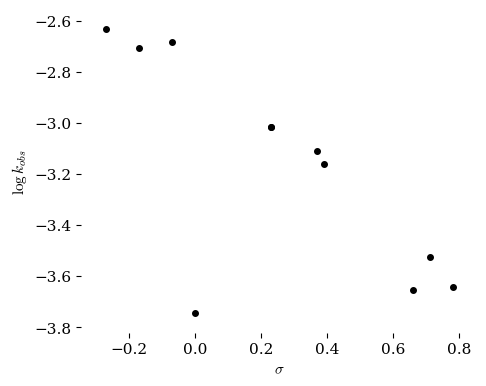

In [89]:
result_copy = result.copy()  # copy the data set into a new data structure so the original will not change

sigmatype = "sigma"   # "sigma", "s_plus", or "s_minus"
x = result_copy[sigmatype]  

column = "kH"  # "Ka", "kOH", "kH2O", "kH"

y = np.log10(result_copy[column])




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress

sigma = sigmatype 


def Report(comment, result):
    print(comment)
    print(f"slope = {result.slope:-.3f} +/- {result.stderr:.3f}")
    print(f"intercept = {result.intercept:-.3f} +/- {result.intercept_stderr:.3f}")
    print(f"rsq = {(result.rvalue)**2:-.3}")
    print(f"p = {(result.pvalue):-.3}")
    print("")


style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"

style_name = github_location_styles + style
plt.style.use(style_name)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.07, y=.07, tight=True)


if sigmatype == "s_plus":
    x_label = r"$\sigma^+$"
elif sigmatype == "s_minus":
    x_label = r"$\sigma^-$"
elif sigmatype == "sigma":
    x_label = r"$\sigma$"
else:
    x_label = "ERROR"

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
         )


##############################

#linfit = linregress(x,y)
#fity = linfit.slope * x + linfit.intercept
#ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)
ax.scatter(x,y, s=64, color="white", marker='o', zorder=3)
ax.scatter(x,y, s=16, color="black", marker='o', zorder=3)

#print("Closed circles")
#Report("48% EtOH, 30 deg", linfit)
